# Fonctions pour le calcul avec le maximum de la vraisemblance

## Lecture et nettoyage des données (code fourni)

In [1]:
using CSV, DataFrames, Gadfly, Distributions, StatsBase

┌ Info: Loading DataFrames support into Gadfly.jl
└ @ Gadfly C:\Users\farme\.julia\packages\Gadfly\09PWZ\src\mapping.jl:228


In [2]:
train = CSV.read("ODtrain.csv")
n = size(train,1)
p = size(train,2)
dropmissing!(train, disallowmissing=true)
str_mode = ["Voiture", "Transport Collectif", "Hybride", "Actif", "Autre"]

d = Array{String}(undef,n)

for i=1:length(str_mode)
   
    ind = train[:D_Mode] .== i
    d[ind] .= str_mode[i] 
    
end

train[:D_Mode_str] = d

categorical!(train, :D_Mode_str);

## Analyse des distributions des données

Ici on peut changer les valeurs des trois premières variables pour tenter de trouver la bonne distribution à associer à une variable quelconque.

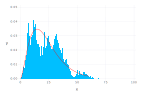

In [3]:
dep = 1;
sym = :M_dist_centre
dist = Gamma

voi = train[train[:D_Mode] .== dep, :];
fd = fit_mle(dist, voi[sym]);
xx = 0:0.1:60;
f = pdf.(fd, xx);
h = layer(x = voi[sym], Geom.histogram(density = true));
f = layer(x = xx, y = f, Geom.line, Theme(default_color="red"));
plot(f, h)

## Fonctions pour le calcul

### Constante

In [4]:
k = 5

5

### Fonctions internes ("privées")

In [5]:
function determineMode(index::Int64, dist::Array{Distribution, 2}, columns::Array{Symbol, 1}, testSet::DataFrame)
    # Y Cat(τ)
    τ = fit(Categorical, train[:D_Mode])
    # P(Y = i | X = dist) = p[i]
    p = Array{Float64}(undef, k)
    max = 1
    for i=1:k
        p[i] = log(pdf(τ, i))
        nVarExpl = size(dist, 1)
        for j=1:nVarExpl
           p[i] += log(pdf(dist[j, i], testSet[columns[j]][index]))
        end
        if p[max] < p[i]
            max = i
        end
    end
    return max
end
function validate(estimates::Array{Int64}, realValue::Array{Int64})
    n = length(realValue)
    nEach = [0, 0, 0, 0, 0]
    right = [0, 0, 0, 0, 0]
    for i=1:n
        nEach[realValue[i]] += 1
        if estimates[i] == realValue[i]
            right[realValue[i]] += 1
        end
    end
    for i=1:k
       print(str_mode[i], " : ", right[i]/nEach[i]*100, "%\n" ) 
    end
    print("Total : ", sum(right)/n*100, "%\n" ) 
end
struct TestSet
    train::DataFrame
    test::DataFrame
end
function getTestSet(initialSet::DataFrame)
    n = length(initialSet[:D_Mode])
    nTest = convert(Int64, round(0.20 * n))
    index = rand(0:n-nTest+1)
    return TestSet(vcat(initialSet[1:index-1, :], initialSet[index+nTest:n, :]), initialSet[index:index+nTest-1, :])
    
    a = [1,2,3]
    b= view(a, 1:2)
    c= vcat(view(a, 1:1), view(a, 3:3))
end

getTestSet (generic function with 1 method)

### Fonction "publique"

In [6]:
function getPercentRight(distType::Array{UnionAll, 2}, columns::Array{Symbol, 1})
    # Séparer les données connues en train et test sets
    set = getTestSet(train)
    
    # Maximum de la vraisemblance pour estimer
    nVariablesExpl = length(columns)
    dist = Array{Distribution}(undef, nVariablesExpl, k)
    for varExpl=1:nVariablesExpl
        for mode=1:k
        trainT = set.train[set.train[:D_Mode] .== mode, :];
        # fit_mle retourne les estimateurs avec le maximum de la vraisemblance.
        dist[varExpl, mode] = fit_mle(distType[varExpl, mode], trainT[Symbol(columns[varExpl])])
        end
    end
    
    # Estimer les valeurs pour l'échantillon de test
    amount = length(set.test[:D_Mode])
    res= Array{Int64}(undef, amount)
    for i=1:amount
       res[i] = determineMode(i, dist, columns, set.test) 
    end
    validate(res, set.test[:D_Mode])
end

getPercentRight (generic function with 1 method)

### Exemple

Ici, on estime que la variable P_PERMIS est distribuée selon une loi Catégorielle.
On pense la même chose pour la variable P_STATUT.
Pour la variable M_dist_centre, on pense plutôt qu'elle suit une loi Gamma.

Pour les trois variables, nous avons donné la même distribution peut-importe la valeur de Y.
Cependant, si nous pensions que lorsque Y = 3, la variable M_dist_centre est distribuée selon une loi normale, nous aurions pu écrire:
Gamma Gamma Normal Gamma Gamma

Les fonctions ci-dessus séparent l'échantillon train en deux portions (4/5 train, 1/5 test). Cette séparation change à toutes les fois où l'algorithme est roulé.
Le résultat de l'appel à getPercentRight est séparé selon le mode de transport.

In [7]:
getPercentRight([
        [Categorical Categorical Categorical Categorical Categorical];
        [Categorical Categorical Categorical Categorical Categorical];
        [Gamma Gamma Gamma Gamma Gamma]
        ], [
        :P_PERMIS,
        :P_STATUT,
        :M_dist_centre
        ])

Voiture : 83.71803731859019%
Transport Collectif : 35.36498936924167%
Hybride : 0.0%
Actif : 27.519151443724223%
Autre : 77.12962962962962%
Total : 63.03281780460204%
